In [17]:
import sys
sys.path.append('/home/sethih1/masque_new/ters_gen')

Device: cuda


/tmp/ipykernel_2866115/300727297.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(model_path), map_location=device)


/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_1.0/test
before the loop
838


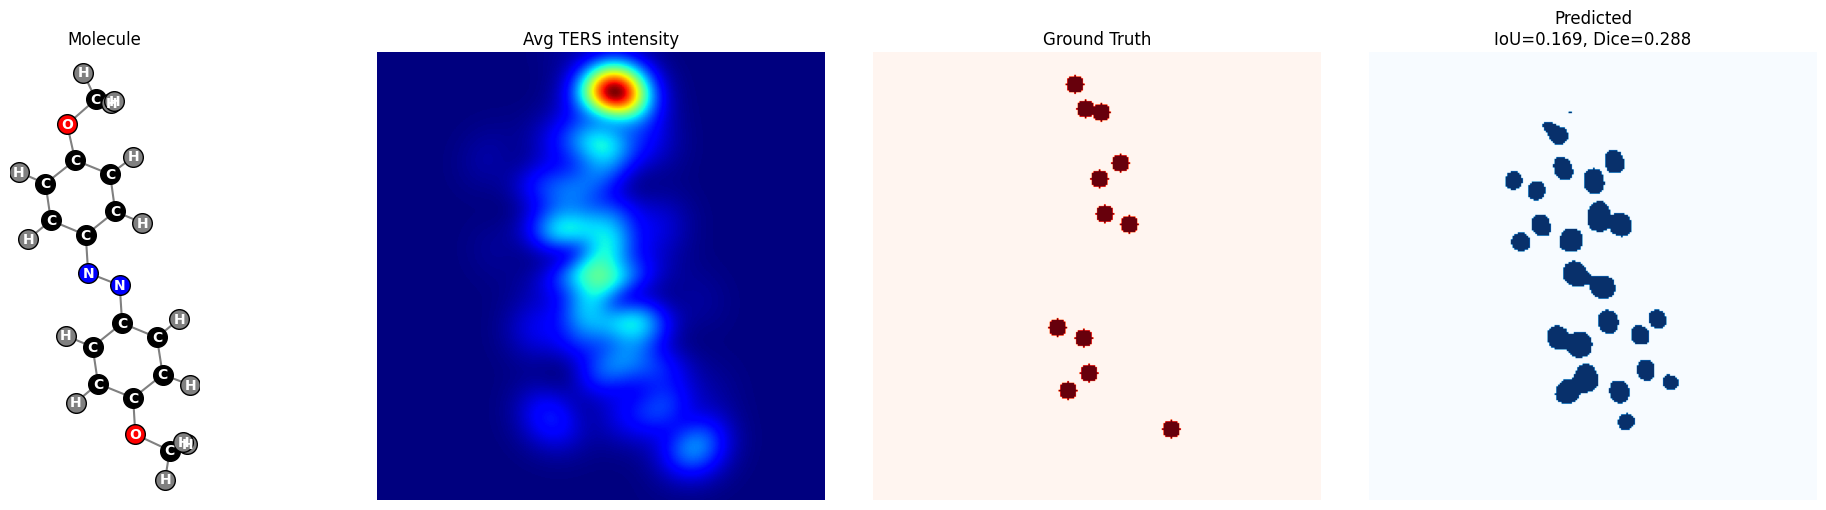

,filename,num_atoms,IoU,Dice
0,10388,32,0.168503,0.288409


In [22]:
# %% [markdown]
# # Single Molecule Inference & Visualization
# 
# This notebook performs inference on a single molecule using a trained model and visualizes:
# - Molecule structure
# - Average TERS intensity
# - Ground truth mask
# - Predicted mask  
# All images are displayed in **one row**.  

# %%
# Ensure inline plotting in Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project-specific imports
from src.datasets import Ters_dataset_filtered_skip
from src.transforms import Normalize, MinimumToZero
from notebooks.utils.read_files import read_npz
from notebooks.utils.planarity import pca, planarity

# %%
# -------------------------
# Helper functions
# -------------------------

def compute_sample_metrics(pred: torch.Tensor, mask: torch.Tensor):
    """Compute IoU and Dice coefficient for binary masks."""
    pred_flat = pred.view(-1).bool()
    mask_flat = mask.view(-1).bool()
    inter = torch.logical_and(pred_flat, mask_flat).sum().float()
    union = torch.logical_or(pred_flat, mask_flat).sum().float()
    iou = (inter / (union + 1e-6)).item()
    dice = (2 * inter / (pred_flat.sum().float() + mask_flat.sum().float() + 1e-6)).item()
    return iou, dice

def try_load_model(model_path: Path, device: str):
    """Load PyTorch model."""
    model = torch.load(str(model_path), map_location=device)
    model.to(device)
    model.eval()
    return model

def get_element_color(atomic_number):
    """Assign colors per element."""
    colors = {1:'gray', 6:'black', 7:'blue', 8:'red', 9:'green'}
    return colors.get(atomic_number, 'gray')

# %%
# -------------------------
# Parameters
# -------------------------

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

num_channels = 100
sg_ch = True

# 1049 
# 148247
# 8027
# Single molecule NPZ file
#molecule_file = Path("/home/sethih1/masque_new/ters_gen/notebooks/interesting_mols/148247.npz")
molecule_file = Path("/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_1.0/test/10388.npz") #13284.npz")

model_path = Path("/scratch/phys/sin/sethih1/Extended_TERS_data/run_planar_again_final_complete/run_planar_npz_1.0/models/best_model.pt")
batch_size = 1

# %%
# -------------------------
# Load model
# -------------------------
model = try_load_model(model_path, device)

# %%
# -------------------------
# Dataset + DataLoader
# -------------------------

from torchvision import transforms as _transforms
data_transform = _transforms.Compose([Normalize(), MinimumToZero()])

print(molecule_file.parent)

dataset = Ters_dataset_filtered_skip(
    filename=molecule_file.parent,
    frequency_range=[0,4000],
    num_channels=num_channels,
    std_deviation_multiplier=2,
    sg_ch=sg_ch,
    t_image=data_transform,
    t_freq=None,
    flag=True
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# %%
# -------------------------
# Inference + Visualization for the single molecule
# -------------------------

print('before the loop')

print(len(loader))
for batch in loader:
    #print('enter')
    try:
        filenames, atom_counts, _, images_b, _, masks_b = batch
    
    except Exception:
        filenames = batch[0]
        atom_counts = batch[1]
        images_b = batch[3]
        masks_b = batch[5]

    # Only process the exact NPZ file
    fname_strs = [f.decode() if isinstance(f, bytes) else f for f in filenames]
    if molecule_file.stem not in fname_strs:
        continue

    #print('hello')
    images_b = images_b.to(device)
    masks_b = masks_b.to(device)

    # Model prediction
    probs = model(images_b)
    preds_b = (probs > 0.5).long().squeeze(1)
    pred_i = preds_b[0].cpu()
    mask_i = masks_b[0].cpu().squeeze()

    # Metrics
    iou, dice = compute_sample_metrics(pred_i, mask_i)
    num_atoms = int(atom_counts[0]) if atom_counts is not None else -1

    # Load coordinates + atomic numbers
    coords, atomic_numbers = read_npz(str(molecule_file))
    atom_pos = coords

    # -------------------------
    # Visualization in one row
    # -------------------------
    # -------------------------
    # Visualization in one row
    # -------------------------
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    
    # 1. Molecule structure
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            if np.linalg.norm(atom_pos[i]-atom_pos[j]) < 1.6:
                axes[0].plot([atom_pos[i,0], atom_pos[j,0]],
                             [atom_pos[i,1], atom_pos[j,1]], 'gray', lw=1.5, zorder=1)


    atomic_number_to_symbol = {
    1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B',
    6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne'
    # add more as needed
}

    
    for i in range(num_atoms):
        x, y, _ = atom_pos[i]
        symbol = atomic_number_to_symbol.get(atomic_numbers[i], 'X')
        color = get_element_color(atomic_numbers[i])
        axes[0].scatter(x, y, s=200, c=color, edgecolors='black', zorder=2)
        axes[0].text(x, y, symbol, fontsize=10, color='white', ha='center', va='center', fontweight='bold')


    
    axes[0].set_aspect('equal')
    axes[0].set_axis_off()
    axes[0].set_title("Molecule")
    
    # 2. Average TERS intensity
    avg_chan = torch.mean(images_b[0].cpu(), dim=0).numpy()
    axes[1].imshow(avg_chan, cmap='jet', origin='lower')
    axes[1].set_title("Avg TERS intensity")
    axes[1].axis('off')
    
    # 3. Ground truth mask
    axes[2].imshow(mask_i, cmap='Reds', origin='lower')
    axes[2].set_title("Ground Truth")
    axes[2].axis('off')
    
    # 4. Predicted mask
    axes[3].imshow(pred_i, cmap='Blues', origin='lower')
    axes[3].set_title(f"Predicted\nIoU={iou:.3f}, Dice={dice:.3f}")
    axes[3].axis('off')
    
    plt.tight_layout()

    plt.show()

    # -------------------------
    # Display metrics table
    # -------------------------
    metrics = pd.DataFrame([{
        "filename": molecule_file.stem,
        "num_atoms": num_atoms,
        "IoU": iou,
        "Dice": dice
    }])
    display(metrics)
    
    break  # only first matching molecule


In [ ]:
data = np.load('/home/sethih1/masque_new/ters_gen/notebooks/interesting_mols//148247.npz')

In [11]:
data['spectrums'].shape

(256, 256, 29)

In [72]:
img = data['spectrums'].mean(axis=2)

In [3]:
plt.imshow(img, cmap='jet', origin='lower')

NameError: name 'img' is not defined

In [67]:
len(dataset)

3

In [33]:
import glob
glob.glob('/home/sethih1/masque_new/ters_gen/notebooks/interesting_mols')

['/home/sethih1/masque_new/ters_gen/notebooks/interesting_mols']

In [3]:
pred_i.shape

NameError: name 'pred_i' is not defined

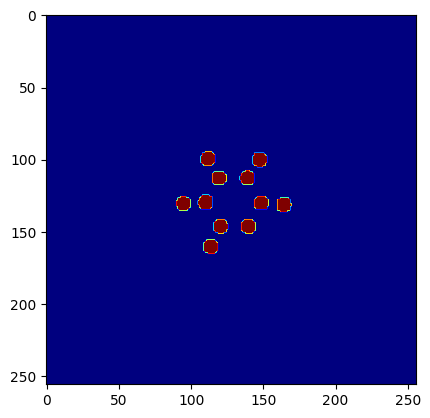

In [79]:
plt.imshow(pred_i, cmap='jet')

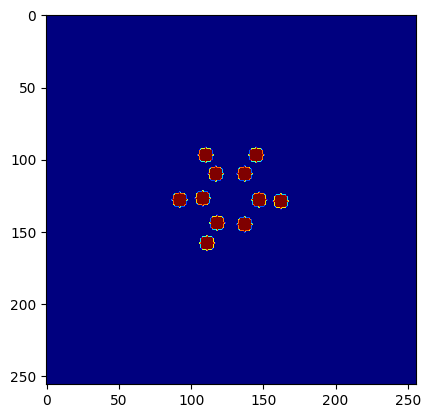

In [80]:
plt.imshow(mask_i, cmap='jet')

In [43]:
mask_i[mask_i > 0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 